### Importing Libraries

In [85]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_context('talk')
sns.set_style("darkgrid")
import math

### Importing Dataset

In [86]:
df = pd.read_csv("C:/Users/abcd/Downloads/data.csv", engine ='python')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### Data Preprocessing

In [87]:
#drop orders with missing customer ID
df = df.dropna(subset = ['CustomerID'])

#remove rows with manual, dotcom postage, etc under description
remove_unit = ['Manual', 'DOTCOM POSTAGE', 'CRUK Commission', 'POSTAGE', 'Discount']
df = df[~df['Description'].isin(remove_unit)]

#remove outliers using interquartile range
def remove_outlier(df_in, col_name):
    Q1 = df_in[col_name].quantile(0.25)
    Q3 = df_in[col_name].quantile(0.75)
    IQR = Q3 - Q1
    df_out = df_in[~((df_in[col_name] < (Q1 - 1.5 * IQR)) | (df_in[col_name] > (Q3 + 1.5 * IQR)))]
    return df_out

#apply function independently on each needed columns 
newunit = remove_outlier(df, 'UnitPrice')
newquantity = remove_outlier(df, 'Quantity')

#merge the two dataframes together
cols = newquantity.columns.difference(newunit.columns)
df = pd.merge(newunit, newquantity[cols], how = 'inner', left_index = True, right_index = True)

#remove matching postive and negative rows
df = df[~df.groupby(['Description', 'CustomerID', 'StockCode', 'Country', 'UnitPrice'])['Quantity'].transform('sum').eq(0)]

#remove remaining rows with negative quantity
df = df[df['Quantity'] > 0]

#create revenue column
df['Revenue'] = df['UnitPrice'] * df['Quantity']

#df.groupby(['Country', 'CustomerID', 'InvoiceNo']).count().head()
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


### Scenario 1

### Let’s imagine the manager of the retail store decides to give some bonus to the highest paying customer in every country, and to do this he assumes that customer who has the highest number of order count per country are the highest paying customers. In other words, he believes that the average revenue generated from these customers is more than the revenue generated from the whole population of customers. Is there enough evidence to accept the manager’s hypothesis?

In [88]:
#select customers with the highest number of orders per country 
k = (df.groupby(['Country'],as_index=False).agg({'CustomerID': pd.Series.mode}))

#inner-join the selection to df to create a dataframe
highest_ord = pd.merge(df, k, how = 'inner', left_on = ['Country', 'CustomerID'], right_on = ['Country', 'CustomerID'])
highest_ord.groupby(['Country', 'CustomerID'], as_index=False).agg(Order_Country = ('InvoiceNo', np.size), Total_revenue = ('Revenue', np.sum))


,Order_Country,Total_revenue
0,Australia,12431.0
1,Austria,12360.0
2,Bahrain,12355.0
3,Belgium,12362.0
4,Brazil,12769.0
5,Canada,17444.0
6,Channel Islands,14936.0
7,Cyprus,12359.0
8,Czech Republic,12781.0
9,Denmark,12406.0


In [89]:
highest_ord.shape

(17101, 9)

In [90]:
#Mean of the Revenue from the whole dataframe
mean = np.mean(df['Revenue'])
mean

12.772932828559997

Text(0.5, 1.0, 'Mean Revenue by Customer Types')

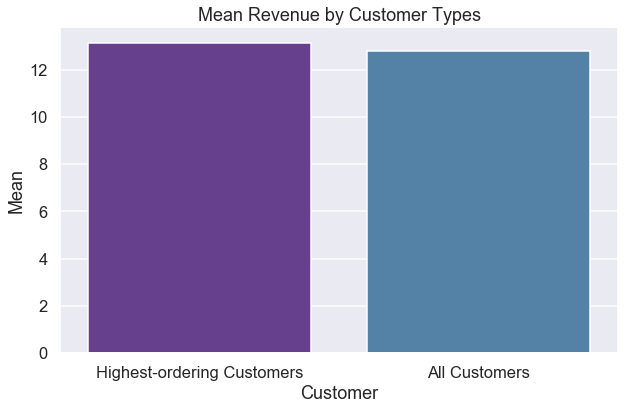

In [91]:
#generate a bar chart for the means
bar1 = pd.DataFrame({'Customer': {0: 'Highest-ordering Customers', 1: 'All Customers'}, 
                   'Mean': {0: highest_ord['Revenue'].mean(), 1: df['Revenue'].mean()}}) 

fig = plt.figure(figsize = (10, 6))
clrs = ['rebeccapurple' if (x == min(bar1)) else 'steelblue' for x in bar1 ]
sns.barplot(x="Customer", y = 'Mean', data = bar1, palette = clrs)
plt.title("Mean Revenue by Customer Types")

#### t-test with p-value

In [92]:
#Null Hypothesis: There is no difference between the sample mean and the hypothesized mean.
#Alternative Hypothesis: The sample mean is greater than the hypothesized mean.

#H0 : μ = 12.77, Ha : μ > 12.77

n = 17101
degrees_of_freedom = n-1
xbar = highest_ord['Revenue'].mean()
mu = df['Revenue'].mean()
s = highest_ord['Revenue'].std()
alpha = 0.05

t = (xbar - mu) / (s / np.sqrt(n))
t

3.4471587791494236

In [93]:
p_val = (1 - stats.t.cdf(abs(t) ,degrees_of_freedom)) #"1 - cdf" because it's a right-tailed test
p_val

0.0002839390302739053

In [94]:
if (p_val > alpha):
    print("Null hypothesis cannot be rejected")
else:
    print("Reject Null hypothesis")

Reject Null hypothesis


### With the result above, we can conclude that the managers assumption is good enough, the average revenue generated from these high -ordering customers is more than the revenue generated from the whole population of customers.

### Scenario 2

### The assistant manager thinks that a customer may actually have high order count but not necessarily high number of units per order. So he recommends that customers with the highest average total units purchased should be given preference instead. But the manager is not sure if there will be any major difference between them. Is there enough evidence to accept the assistant manager’s hypothesis?

In [95]:
#obtain average quantity bought per customer
h =(df.groupby(['Country', 'CustomerID']).agg(mean_quantity = ('Quantity', np.mean)))

#Select customers with the highest average mean count per country
h = pd.DataFrame(h.groupby(level=0)['mean_quantity'].nlargest(1))
h.index = h.index.droplevel()

#inner-join the selection to create highest average quantity dataframe
highest_quant = pd.merge(df, h.reset_index(), how = 'inner', left_on = ['Country', 'CustomerID'], right_on = ['Country', 'CustomerID'])
highest_quant.groupby(['Country', 'CustomerID'], as_index=False).agg(Mean_Country = ('Quantity', np.mean), Total_revenue = ('Revenue', np.sum))


,Mean_Country,Total_revenue
0,Australia,12415.0
1,Austria,12817.0
2,Bahrain,12355.0
3,Belgium,12364.0
4,Brazil,12769.0
5,Canada,17444.0
6,Channel Islands,14937.0
7,Cyprus,12455.0
8,Czech Republic,12781.0
9,Denmark,12435.0


In [96]:
highest_quant.shape

(1434, 10)

In [97]:
df['Revenue'].mean() 

12.772932828559997

In [98]:
highest_quant['Revenue'].mean() 

26.671645746164586

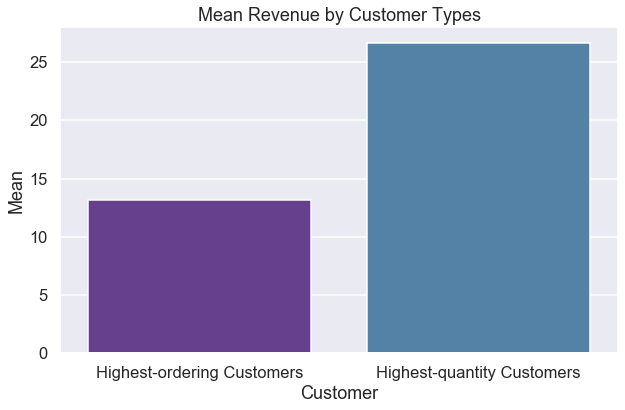

In [99]:
bar2 = pd.DataFrame({'Customer': {0: 'Highest-ordering Customers', 1: 'Highest-quantity Customers'}, 
                   'Mean': {0: highest_ord['Revenue'].mean(), 1: highest_quant['Revenue'].mean()}})

fig = plt.figure(figsize = (10, 6))
clrs1 = ['rebeccapurple' if (x == min(bar2)) else 'steelblue' for x in bar2 ]
sns.barplot(x="Customer", y = 'Mean', data = bar2, palette = clrs1)
plt.title("Mean Revenue by Customer Types");

#### t-test with p-value

In [100]:
#Null Hypothesis: There is no difference between the sample mean and the hypothesized mean.
#Alternative Hypothesis: The sample mean is different from the hypothesized mean.

#H0 : μ = 12.77, Ha : μ != 12.77
n = 1434
degrees_of_freedom = n-1
xbar = highest_quant['Revenue'].mean()
mu = df['Revenue'].mean()
s = highest_quant['Revenue'].std()
alpha = 0.05


t = (xbar - mu) / (s / np.sqrt(n))
t

24.287713480343267

In [101]:
p = (1 - st.t.cdf(abs(t) ,degrees_of_freedom))*2 #since, this is a 2-tailed test, we are multiplying by 2
p
#The closer to 0.0 the p-value is, the better or more significant is the result we have obtained.

0.0

In [102]:
if (p > alpha):
    print("Null hypothesis cannot be rejected")
else:
    print("Reject Null hypothesis")

Reject Null hypothesis


### With the result above, we can accept the assistant manager’s hypothesis of rewarding customers who purchased the highest average quantity of goods.